## Preparation

In [ ]:
# Import the libraries we need for this lab
import torch
from torch import nn
from torch import sigmoid
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0)

In the provided code, the `.detach()` function is used on the output of `model(X)` before converting it to a NumPy array for plotting. Here's an explanation of its purpose:

### Purpose of `.detach()`:
1. **Detach from Computation Graph**:
   - In PyTorch, tensors involved in operations with `requires_grad=True` are part of the computation graph. This graph is used for backpropagation to compute gradients during model training.
   - `.detach()` creates a new tensor that shares the same data as the original tensor but is not part of the computation graph. This means any operations performed on the detached tensor will not be tracked for gradient calculations.

2. **Avoid Gradient Tracking in Plotting**:
   - The output of `model(X)` is likely a tensor that requires gradient computation (e.g., if `X` requires gradients or the model is being trained).
   - When passing this tensor to `numpy()` (via `.detach().numpy()`), you must detach it first because `numpy()` does not support tensors that require gradients or are part of the computation graph.

3. **Efficiency**:
   - Detaching the tensor avoids unnecessary memory usage and computation overhead associated with gradient tracking when all you need is to visualize the data.

### Why is `.numpy()` used after `.detach()`?
PyTorch tensors can be converted to NumPy arrays for use in libraries like Matplotlib. However, this is only allowed for tensors on the CPU and those that do not require gradients. The sequence `.detach().numpy()` ensures both conditions are met:
- `.detach()`: Removes gradient tracking.
- `.numpy()`: Converts the tensor to a NumPy array.

### Code Explanation:
```python
plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
```
- `X.numpy()`: Converts the input `X` (which is assumed to be a PyTorch tensor) to a NumPy array for plotting the x-axis.
- `model(X)`: Computes the model's output for the input `X`.
- `.detach().numpy()`: Detaches the output tensor from the computation graph and converts it to a NumPy array for plotting the y-axis.

### Summary:
The `.detach()` function is essential in this context to ensure the output of `model(X)` is not part of the computation graph and can be safely converted to a NumPy array for plotting without interfering with PyTorch's gradient computations or causing runtime errors.

In [ ]:
# The function for plotting the model
def plotStuff(X, Y, model, epoch, leg=True):
  plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch' + str(epoch)))
  plt.plot(X.numpy(), Y.numpy(), 'r')
  plt.xlabel('x')
  if leg=True:
    plt.legend()
  else:
    pass

## Neural Network Module and Training Function

In [ ]:
# Define the class Net
class Net(nn.Module):

  # Constructor
  def __init__(self, D_in, H, D_out):
    super(Net, self).__init__()
    # hidden layer
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, D_out)
    # Define first linear layer as an attribute (bad practice)
    self.a1 = None
    self.l1 = None
    self.a2 = None

  # Prediction
  def forward(self, x):
    self.l1 = self.linear1(x)
    self.a1 = sigmoid(self.l1)
    self.l2 = self.linear2(self.a1)
    yhat = sigmoid(self.linear2(self.a1))
    return yhat

These three functions are fundamental steps in the training loop of a PyTorch model. Here's a brief explanation of each:

---

### 1. **`loss.backward()`**
   - **Purpose**: Computes the gradients of the loss with respect to the model parameters.
   - **How it works**:
     - PyTorch builds a computational graph dynamically during the forward pass.
     - When you call `loss.backward()`, it traverses this graph in reverse (backpropagation) and calculates gradients for all tensors in the graph that have `requires_grad=True`.
   - **Usage**: This step is necessary to update the model's parameters during training.

---

### 2. **`optimizer.step()`**
   - **Purpose**: Updates the model's parameters using the computed gradients.
   - **How it works**:
     - The `optimizer` (e.g., SGD, Adam) contains information about the model's parameters and how they should be updated (e.g., based on learning rate).
     - When `optimizer.step()` is called, it applies the optimization algorithm to adjust the model parameters based on the gradients computed in the `loss.backward()` step.
   - **Usage**: This is the step where the actual parameter updates occur.

---

### 3. **`optimizer.zero_grad()`**
   - **Purpose**: Clears the gradients of all parameters in the optimizer.
   - **Why needed**:
     - Gradients in PyTorch accumulate by default. If you don't zero them out, gradients from previous iterations will be added to the current ones, leading to incorrect updates.
   - **How it works**:
     - Resets the gradients of all the parameters managed by the optimizer to zero, ensuring the next backpropagation starts fresh.

---

### Typical Training Loop Example:
```python
for epoch in range(num_epochs):
    optimizer.zero_grad()         # Clear previous gradients
    outputs = model(inputs)       # Forward pass
    loss = criterion(outputs, labels)  # Compute loss
    loss.backward()               # Backpropagation (compute gradients)
    optimizer.step()              # Update model parameters
```

### Summary:
- **`loss.backward()`**: Computes gradients.
- **`optimizer.step()`**: Updates model parameters using gradients.
- **`optimizer.zero_grad()`**: Clears old gradients to prevent accumulation.

In [ ]:
# Define the training function
def train(Y, X, model, optimizer, criterion, epochs=1000):
  cost = []
  total = 0

  for epoch in range(epochs):
    total = 0
    for y, x in zip(Y, X):
      yhat = model(x)
      loss = criterion(yhat, y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      # Cumulative loss
      total += loss.item()
    cost.append(total)
    if epoch % 300 == 0:
      plotStuff(X, Y, model, epoch, leg=True)
      plt.show()
      model(X)
      plt.scatter(model.a1.detach().numpy()[:, 0], model.a1.detach().numpy()[:, 1], c=Y.numpy().reshape(-1))
      plt.title('activations')
      plt.show()
  return cost

## Make Some Data

In [ ]:
# Make some data
X = torch.arange(-20, 20, 1).view(-1, 1).type(torch.FloatTensor)
Y = torch.zeros(X.shape[0])
Y[(X[:, 0] > -4) & (X[:, 0] < 4)] = 1.0

In [ ]:
print(X, Y)

tensor([[-20.],
        [-19.],
        [-18.],
        [-17.],
        [-16.],
        [-15.],
        [-14.],
        [-13.],
        [-12.],
        [-11.],
        [-10.],
        [ -9.],
        [ -8.],
        [ -7.],
        [ -6.],
        [ -5.],
        [ -4.],
        [ -3.],
        [ -2.],
        [ -1.],
        [  0.],
        [  1.],
        [  2.],
        [  3.],
        [  4.],
        [  5.],
        [  6.],
        [  7.],
        [  8.],
        [  9.],
        [ 10.],
        [ 11.],
        [ 12.],
        [ 13.],
        [ 14.],
        [ 15.],
        [ 16.],
        [ 17.],
        [ 18.],
        [ 19.]]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


## Define the Neural Network, Criterion Function, Optimizer and Train the Model

In [ ]:
# The loss function
def criterion_cross(outputs, labels):
  out = -1 * torch.mean(labels * torch.log(outputs) + (1 - labels) * torch.log(1 - outputs))
  return out

def criterion_MSE_cross(outputs, labels):
  out = torch.mean((outputs-labels)**2)
  return out

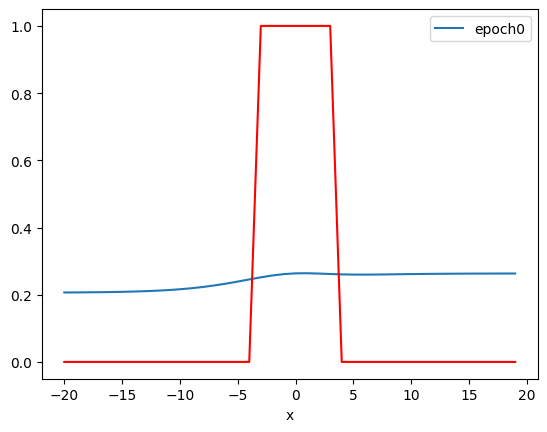

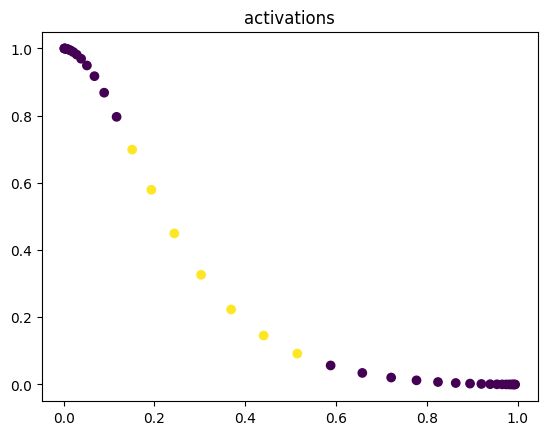

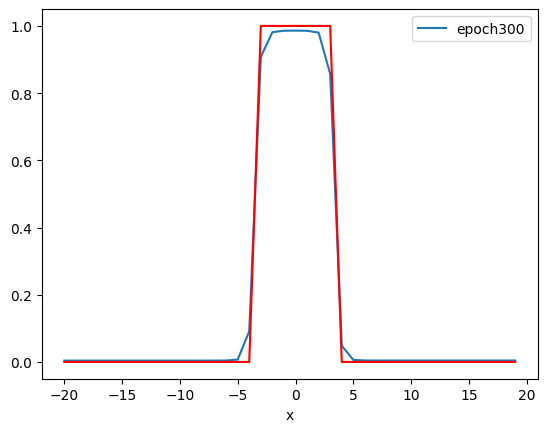

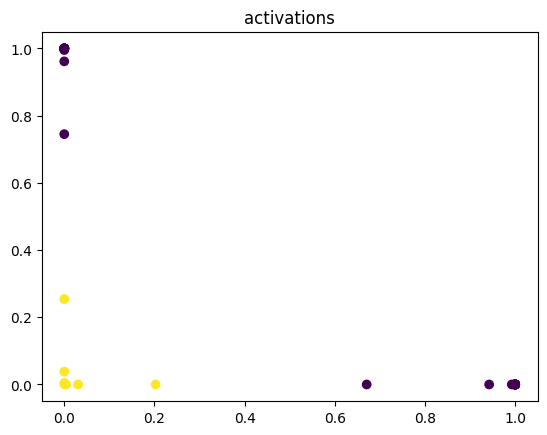

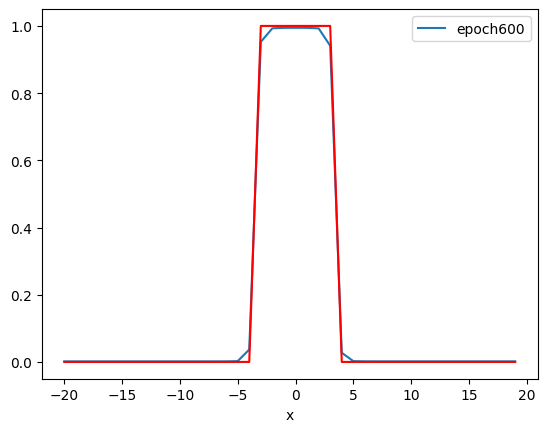

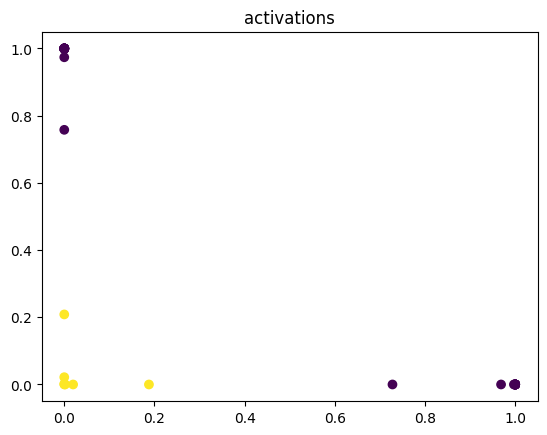

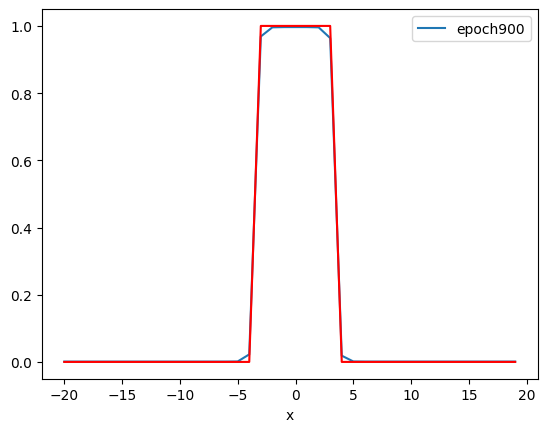

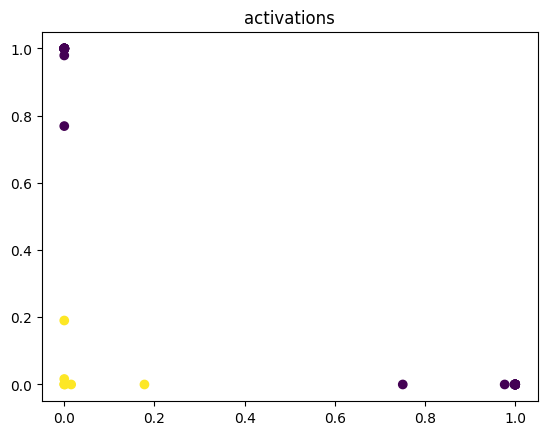

Text(0.5, 1.0, 'cross entropy loss')

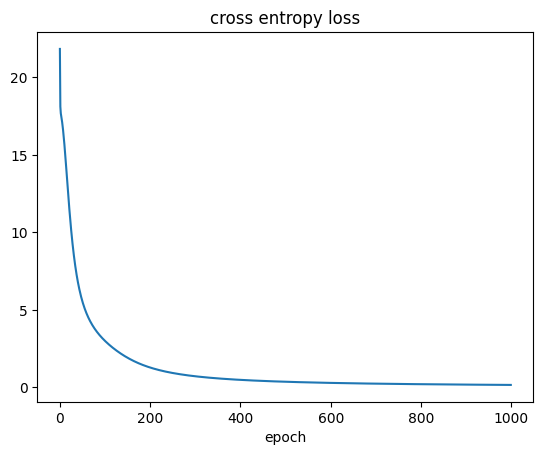

In [ ]:
# Train the model
# size of input
D_in = 1
# size of hidden layer
H = 2
# number of outputs
D_out = 1
# learning rate
learning_rate = 0.1
# create the model
model = Net(D_in, H, D_out)
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#train the model usein
cost_cross = train(Y, X, model, optimizer, criterion_cross, epochs=1000)
#plot the loss
plt.plot(cost_cross)
plt.xlabel('epoch')
plt.title('cross entropy loss')

In [ ]:
x = torch.tensor([0.0])
yhat = model(x)
yhat

tensor([0.9969], grad_fn=<SigmoidBackward0>)

In [ ]:
x = torch.tensor([[0.0], [2.0], [3.0]])
yhat = model(x)
yhat

tensor([[0.9969],
        [0.9963],
        [0.9680]], grad_fn=<SigmoidBackward0>)

In [ ]:
Yhat = yhat > 0.5
Yhat

tensor([[True],
        [True],
        [True]])

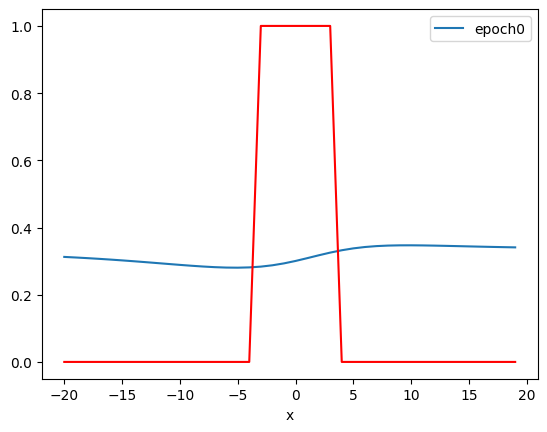

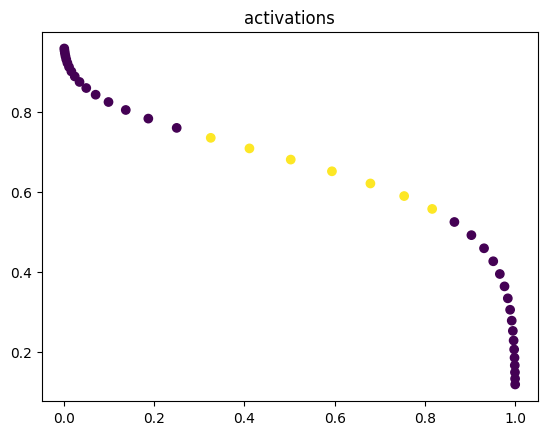

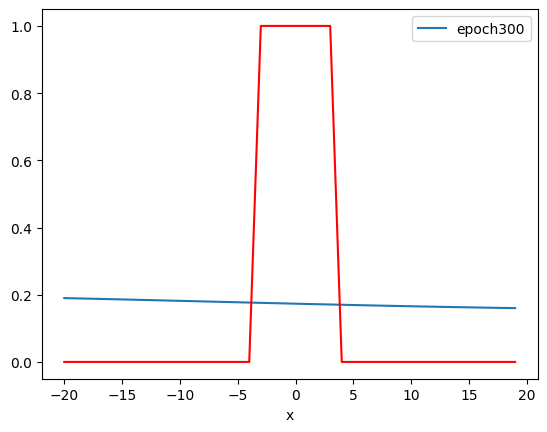

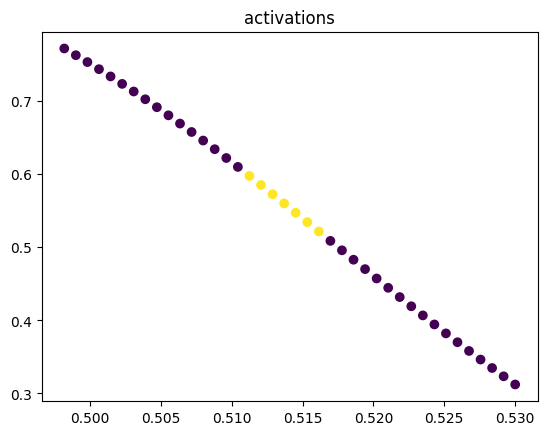

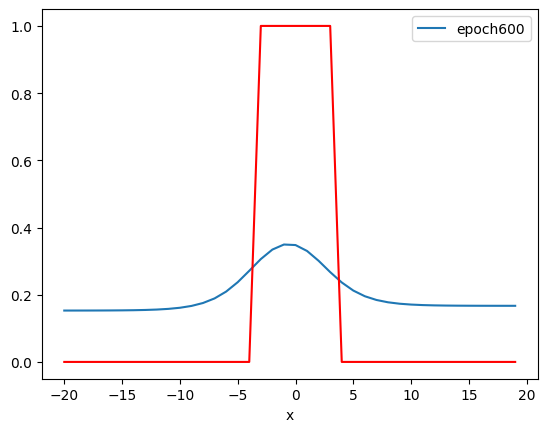

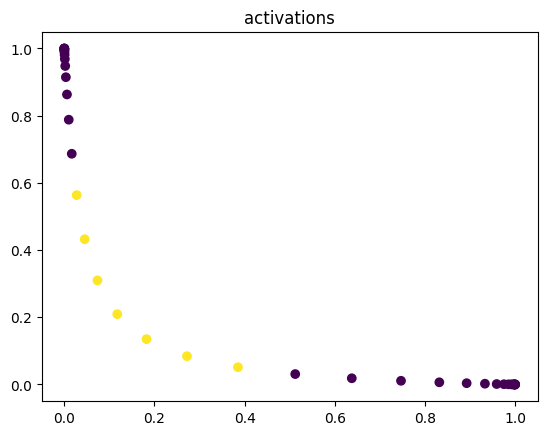

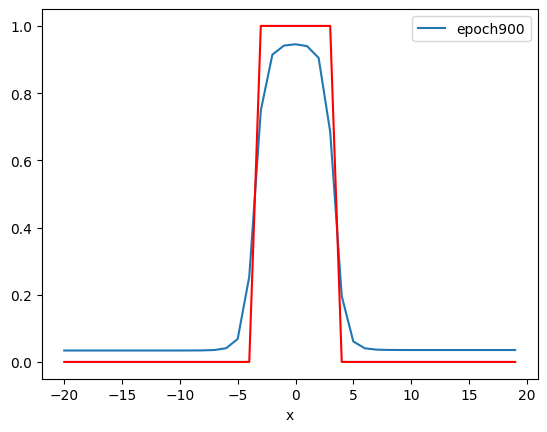

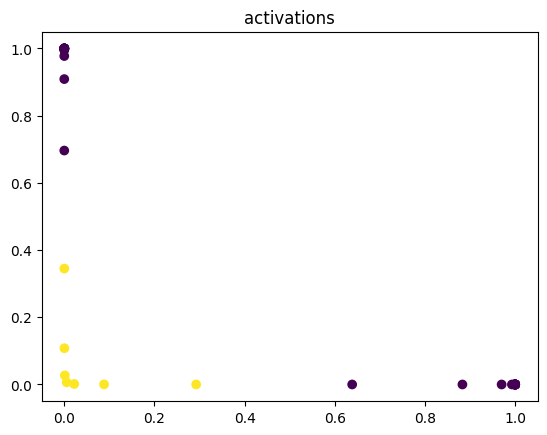

Text(0.5, 1.0, 'cross entropy loss')

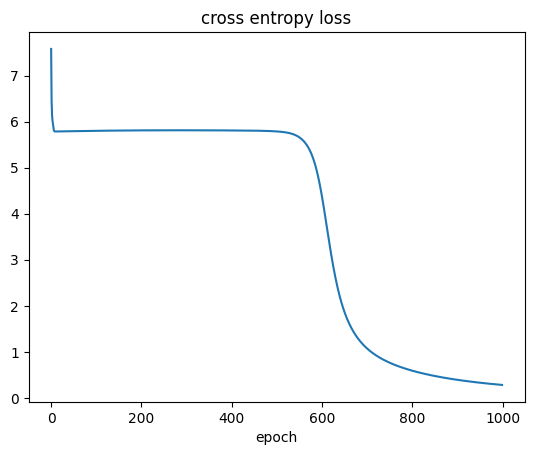

In [ ]:
# Train the model
# size of input
D_in = 1
# size of hidden layer
H = 2
# number of outputs
D_out = 1
# learning rate
learning_rate = 0.1
# create the model
model = Net(D_in, H, D_out)
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#train the model usein
cost_cross = train(Y, X, model, optimizer, criterion_MSE_cross, epochs=1000)
#plot the loss
plt.plot(cost_cross)
plt.xlabel('epoch')
plt.title('cross entropy loss')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


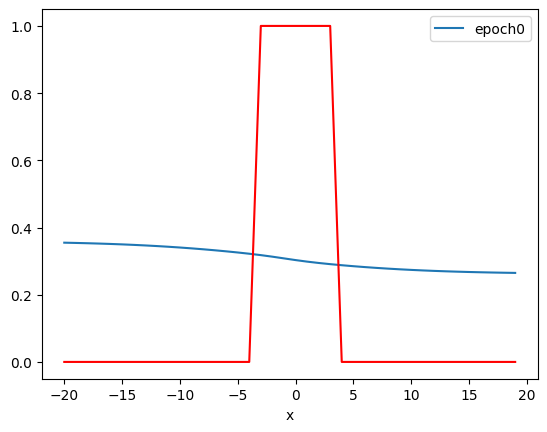

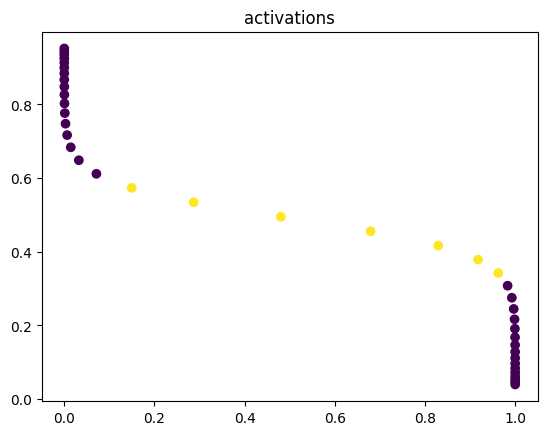

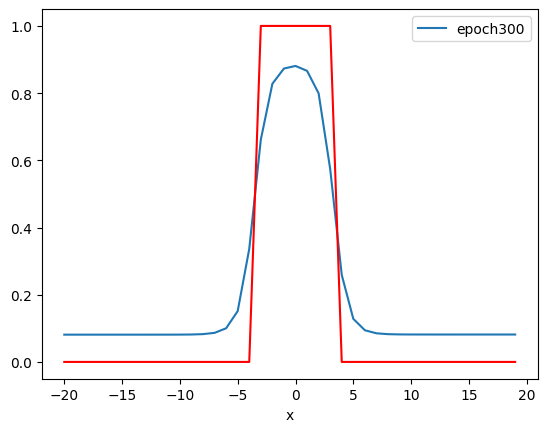

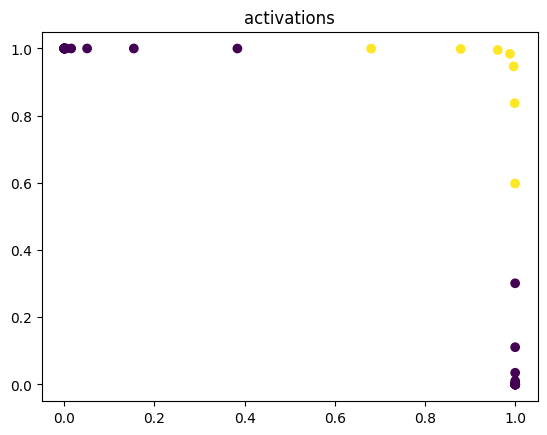

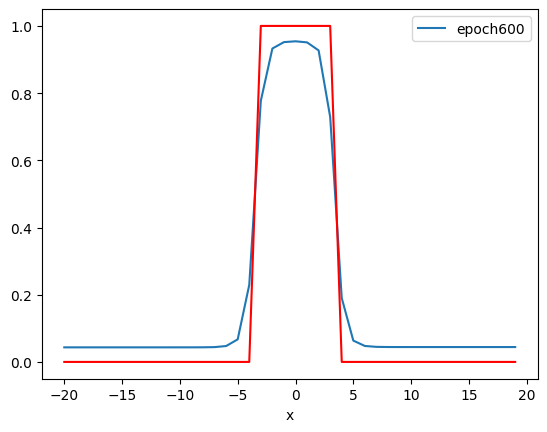

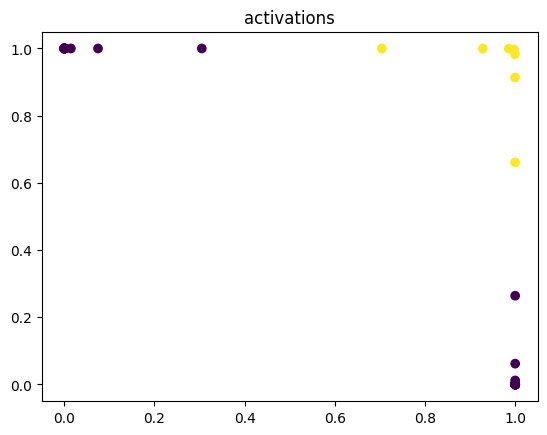

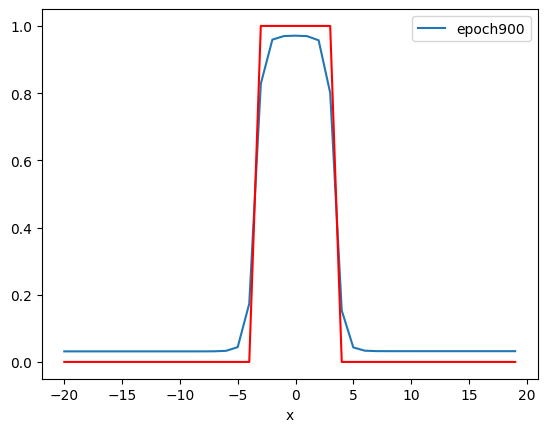

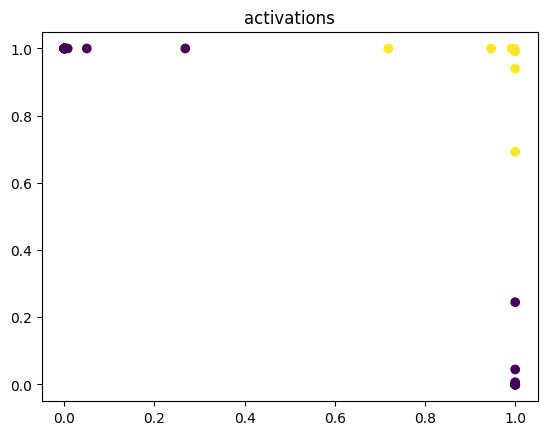

Text(0.5, 1.0, 'MSE loss ')

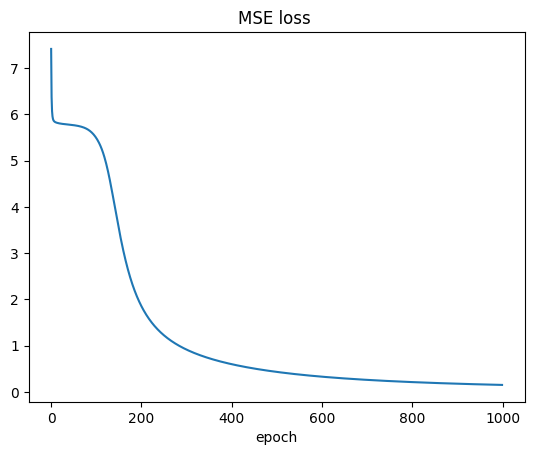

In [ ]:
learning_rate = 0.1
criterion_mse=nn.MSELoss()
model=Net(D_in,H,D_out)
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
cost_mse=train(Y,X,model,optimizer,criterion_mse,epochs=1000)
plt.plot(cost_mse)
plt.xlabel('epoch')
plt.title('MSE loss ')